In [32]:
import cv2
import os
import sys
import time
import re
import traceback
import numpy as np
from matplotlib import pyplot as plt

from utils.chromo_cv_utils import find_external_contours, cv_imread, cv_imwrite
from karyotype import Karyotype

In [33]:
# KYT_IMG_FP = 'D:\\download\\L2311245740.008.K.TIF'
# KYT_IMG_FP = 'D:\\Prj\\github\\woodpecker\\test\\test_img\\L2311245727.001.K.TIF'
# KYT_IMG_FP = 'D:\\Prj\\github\\woodpecker\\test\\test_img\\L2311245740.008.K.TIF'
# KYT_IMG_FP = 'D:\\Prj\\github\\woodpecker\\test\\test_img\\L2311245740.031.K.TIF'
KYT_IMG_FP = r'E:\染色体测试数据\240204-评估240202测试集AI推理结果\KYT_IMG\A2312269442.005.K.JPG'

SAVE_DIR = r'.\test\test_img'

kyt_img_dir, kyt_img_fn = os.path.split(KYT_IMG_FP)
kyt_img_fbn = os.path.splitext(kyt_img_fn)[0]
kyt_img_fext = os.path.splitext(KYT_IMG_FP)[1]

kyt_img_save_dir = f"{os.path.join(SAVE_DIR, kyt_img_fbn)}"

if not os.path.exists(kyt_img_save_dir):
    os.makedirs(kyt_img_save_dir)

kyt_img_dir, kyt_img_fn, kyt_img_fbn, kyt_img_fext, kyt_img_save_dir

('E:\\染色体测试数据\\240204-评估240202测试集AI推理结果\\KYT_IMG',
 'A2312269442.005.K.JPG',
 'A2312269442.005.K',
 '.JPG',
 '.\\test\\test_img\\A2312269442.005.K')

In [34]:
BIN_THRESH = 253
BIN_THRESH_DELTA = 10

In [35]:
karyotype_chart = Karyotype(KYT_IMG_FP)
karyotype_chart.read_karyotype()
print(1)

1


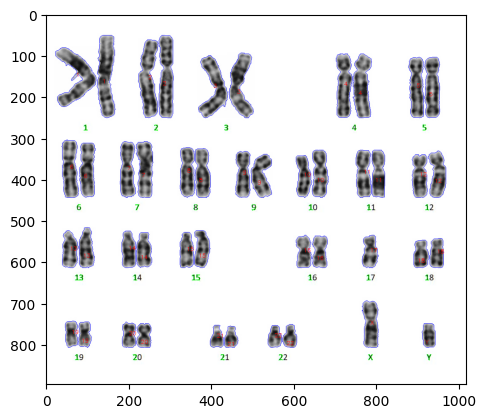

In [36]:
canvas = cv_imread(KYT_IMG_FP)

# 先画编号的轮廓
for cntrs in karyotype_chart.id_cntr_dicts_orgby_cy.values():
    for cntr in cntrs:
        cv2.drawContours(canvas, [cntr["cntr"]], -1, (0, 255, 0), 1)

# 再画染色体的轮廓，并将编号打印在染色体的中间位置
for cntrs in karyotype_chart.chromo_cntr_dicts_orgby_cy.values():
    for idx, cntr in enumerate(cntrs):
        cv2.drawContours(canvas, [cntr["cntr"]], -1, (0, 0, 255), 1)
        x = cntr["cx"]
        y = cntr["cy"]
        if idx % 2 == 0:
            cv2.putText(
                canvas,
                cntr["chromo_id"],
                (x, y),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.45,
                (255, 0, 0),
                1,
            )
        else:
            cv2.putText(
                canvas,
                cntr["chromo_id"],
                (x - 8, y + 20),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.45,
                (255, 0, 0),
                1,
            )

kyt_img_dir, kyt_img_fn = os.path.split(KYT_IMG_FP)
kyt_img_fbn = os.path.splitext(kyt_img_fn)[0]

SAVE_DIR = os.path.join(SAVE_DIR, kyt_img_fbn)

new_img_fp = f"{os.path.join(kyt_img_save_dir, kyt_img_fbn)}_id-on-cntr.png"
cv_imwrite(new_img_fp, canvas)

plt.imshow(canvas) 

In [37]:
# AI_RST_ROOT_DIR = 'D:\\Prj\\github\\woodpecker\\test\\test_img\\2023-12-05_L2311245727.001_L2311245727.001_None_train_data_two'
# AI_RST_ROOT_DIR = 'D:\\Prj\\github\\woodpecker\\test\\test_img\\2023-12-05_L2311245740.008_L2311245740.008_None_train_data_two'
AI_RST_ROOT_DIR = r'E:\染色体测试数据\240204-评估240202测试集AI推理结果\AI_RESULT\A2312269442.005'

ai_rst_dict_orgby_id = {}

In [38]:
# Get Chromo Image from AI Result Dir and organized by chromo index
for id_dir in sorted(os.listdir(AI_RST_ROOT_DIR), key=lambda x: int(x)):
    id_dir_fp = os.path.join(AI_RST_ROOT_DIR, id_dir)
    if not os.path.isdir(id_dir_fp):
        continue

    if int(id_dir) not in ai_rst_dict_orgby_id:
        ai_rst_dict_orgby_id[int(id_dir)] = []

    for fn in os.listdir(id_dir_fp):
        fn_fp = os.path.join(id_dir_fp, fn)
        if not os.path.isfile(fn_fp):
            continue
        
        img = cv_imread(fn_fp)
        if img is None:
            continue

        if int(id_dir) <= 21:
            chromo_id = str(int(id_dir)+1).zfill(2)
        elif int(id_dir) == 22:
            chromo_id = 'X'
        elif int(id_dir) == 23:
            chromo_id = 'Y'

        # guess proper bin threshold
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) if len(img.shape) == 3 else img
        adaptive_method = cv2.THRESH_BINARY_INV + cv2.THRESH_TRIANGLE
        bin_thresh = 0
        bin_thresh, _ = cv2.threshold(gray_img, bin_thresh, 255, adaptive_method)
        # 根据经验值校正二值化阈值
        bin_thresh = bin_thresh - BIN_THRESH_DELTA
        chromo_cntr = find_external_contours(img, bin_thresh)[0]

        grayscale = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        chromo_mask = np.zeros_like(grayscale, dtype=np.uint8)
        cv2.drawContours(chromo_mask, [chromo_cntr], -1, 255, thickness=cv2.FILLED)
        chromo_roi = cv2.bitwise_and(grayscale, grayscale, mask=chromo_mask)

        position_idx = int(os.path.splitext(fn)[0])
        
        ai_rst_dict_orgby_id[int(id_dir)].append({
            'img': img, 
            'chromo_idx': id_dir, 
            'chromo_id': chromo_id,
            'cntr': chromo_cntr, 
            'roi': chromo_roi,
            'position_idx': position_idx})

In [39]:
# 将核型图中的染色体信息按照染色体索引号组织
kyt_rst = {}
# dst_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) if len(img.shape) == 3 else img
grayscale = cv2.cvtColor(karyotype_chart.img['img'], cv2.COLOR_BGR2GRAY) if len(karyotype_chart.img['img'].shape) == 3 else karyotype_chart.img['img']
for cntr_dicts in karyotype_chart.chromo_cntr_dicts_orgby_cy.values():
    for cntr_dict in cntr_dicts:
        if cntr_dict['chromo_idx'] not in kyt_rst:
            kyt_rst[cntr_dict['chromo_idx']] = []
        chromo_mask = np.zeros_like(grayscale, dtype=np.uint8)
        cv2.drawContours(chromo_mask, [cntr_dict['cntr']], -1, 255, thickness=cv2.FILLED)
        chromo_roi = cv2.bitwise_and(grayscale, grayscale, mask=chromo_mask)
        cntr_dict['roi'] = chromo_roi
        kyt_rst[cntr_dict['chromo_idx']].append(cntr_dict)

In [40]:
# ai_rst_simple_lst
ai_rst_simple_lst = []
ids = sorted(ai_rst_dict_orgby_id.keys(), key=lambda x: int(x))
for id in ids:
    img_dicts = ai_rst_dict_orgby_id[id]
    for img_dict in img_dicts:
        ai_rst_simple_lst.append(img_dict)
# 按照chromo_idx排序
ai_rst_simple_lst = sorted(ai_rst_simple_lst, key=lambda item: item['chromo_idx'])

In [41]:
# kyt_rst_simple_lst
kyt_rst_simple_lst = []
for cntr_dicts in karyotype_chart.chromo_cntr_dicts_orgby_cy.values():
    position_idx = 0
    cur_chromo_id = None
    for cntr_dict in cntr_dicts:
        if cur_chromo_id == None:
            cur_chromo_id = cntr_dict['chromo_id']
        if cur_chromo_id != cntr_dict['chromo_id']:
            position_idx = 0
            cur_chromo_id = cntr_dict['chromo_id']
        cntr_dict['position_idx'] = position_idx
        kyt_rst_simple_lst.append(cntr_dict)
        position_idx += 1
# 按照chromo_idx排序
kyt_rst_simple_lst = sorted(kyt_rst_simple_lst, key=lambda item: item['chromo_idx'])

In [42]:
def sift_similarity_on_roi(roi1, roi2):
    """_summary_

    Args:
        roi1 (_type_): Region of interest 1.
        roi2 (_type_): Region of interest 2.

    Returns:
        float: similarity score in %
    """
    # Initialize SIFT detector
    sift = cv2.SIFT_create()

    # Detect keypoints and compute descriptors for ROIs
    keypoints1, descriptors1 = sift.detectAndCompute(roi1, None)
    keypoints2, descriptors2 = sift.detectAndCompute(roi2, None)

    # Match descriptors between ROIs
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(descriptors1, descriptors2, k=2)

    good_matches = [[m] for m, n in matches if m.distance < 0.75 * n.distance]
    # Calculate similarity score based on the number of good matches
    similarity = len(good_matches) / max(len(keypoints1), len(keypoints2)) * 100
    # print(f"Similarity: {similarity:.2f}%")
    return similarity

def sift_similarity_on_roi_ex(roi1, roi2):
    """_summary_

    Args:
        roi1 (_type_): Region of interest 1.
        roi2 (_type_): Region of interest 2.

    Returns:
        float: similarity score in %
    """
    # Initialize SIFT detector
    sift = cv2.SIFT_create()

    # Detect keypoints and compute descriptors for ROIs
    keypoints1, descriptors1 = sift.detectAndCompute(roi1, None)
    keypoints2, descriptors2 = sift.detectAndCompute(roi2, None)

    # Match descriptors between ROIs
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(descriptors1, descriptors2, k=2)

    good_matches = [[m] for m, n in matches if m.distance < 0.75 * n.distance]
    # Calculate similarity score based on the number of good matches
    similarity = len(good_matches) / max(len(keypoints1), len(keypoints2)) * 100
    # print(f"Similarity: {similarity:.2f}%")
    return similarity, keypoints1, keypoints2, good_matches

def flann_similarity_on_roi(roi1, roi2):
    """_summary_

    Args:
        roi1 (_type_): Region of interest 1.
        roi2 (_type_): Region of interest 2.

    Returns:
        float: similarity score in %
    """
    # Initialize SIFT detector
    sift = cv2.SIFT_create()

    # Detect keypoints and compute descriptors for ROIs
    key1, des1 = sift.detectAndCompute(roi1, None)
    key2, des2 = sift.detectAndCompute(roi2, None)

    # FLANN parameters
    FLANN_INDEX_KDTREE = 1
    index_params = dict (algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks=50) # or pass empty dictionary

    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1, des2, k=2)
    
    # Match descriptors between ROIs
    #bf = cv2.BFMatcher()
    #matches = bf.knnMatch(descriptors1, descriptors2, k=2)

    good_matches = [[m] for m, n in matches if m.distance < 0.75 * n.distance]
    # Calculate similarity score based on the number of good matches
    similarity = len(good_matches) / max(len(key1), len(key2)) * 100
    # print(f"Similarity: {similarity:.2f}%")
    return similarity

In [43]:
def contour_bbox_img(img, contour):
    """
    Get the bounding box img of a contour.

    Args:
        img: Image.
        contour: Contour.

    Returns:
        cropped: Bounding box image, with grayscale and black background.
        target_on_white: Bounding box image, with white background, not grayscale.
    """
    # if not grayscale, convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) if len(img.shape) == 3 else img

    # Create a mask for the contour
    mask = np.zeros_like(gray)
    cv2.drawContours(mask, [contour], -1, 255, thickness=cv2.FILLED)

    # Extract the target
    extracted = cv2.bitwise_and(gray, gray, mask=mask)

    # get bounding box of the contour
    x, y, w, h = cv2.boundingRect(contour)

    # Crop the object with some padding, adjust padding as needed
    padding = 1
    cropped = extracted[y - padding : y + h + padding, x - padding : x + w + padding]

    # make it white background
    wbg_cropped = np.full_like(cropped, 255, dtype=np.uint8)
    np.copyto(wbg_cropped, cropped, where=(cropped > 0))

    # grayscal
    # wbg_cropped = cv2.cvtColor(wbg_cropped, cv2.COLOR_RGB2GRAY)

    return cropped, wbg_cropped

In [44]:
def sharpen(img):
    kernel_sharpening = np.array([[-1, -1, -1], 
                                  [-1, 15, -1], 
                                  [-1, -1, -1]])
    return cv2.filter2D(img, -1, kernel_sharpening)

def clahe_image(image, clip_limit, tileGridSize):
    """
        clip_limit 取值 0, 4, 10
        tileGridSize 取值 (2,2), (4,4), (8,8) (16,16)
    """
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tileGridSize)
    return clahe.apply(image)

((107, 21), (107, 21))

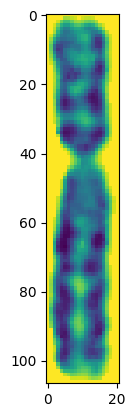

In [45]:
bbg_bbox, wbg_bbox = contour_bbox_img(ai_rst_simple_lst[2]['img'], ai_rst_simple_lst[2]['cntr'])
plt.imshow(wbg_bbox)
bbg_bbox.shape, wbg_bbox.shape

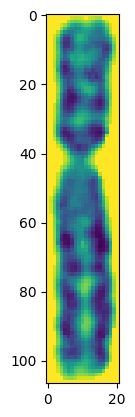

In [46]:
plt.imshow(cv2.flip(wbg_bbox, 1))

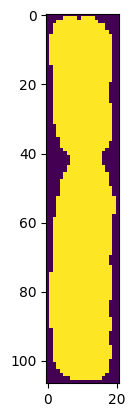

In [47]:
_, dst_img = cv2.threshold(wbg_bbox, 253, 255, cv2.THRESH_BINARY_INV)
plt.imshow(dst_img)

In [48]:
contours, _ = cv2.findContours(dst_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
len(contours)

1

In [49]:
# 按最小矩形对AI结果的染色体和核型图上的染色体按bounding box形成图片在进行对比
for ai_rst in ai_rst_simple_lst:
    bbg_bbox, wbg_bbox = contour_bbox_img(ai_rst['img'], ai_rst['cntr'])
    ai_rst['bbg_bbox'] = bbg_bbox
    ai_rst['wbg_bbox'] = wbg_bbox
    _, dst_img = cv2.threshold(wbg_bbox, 253, 255, cv2.THRESH_BINARY_INV)
    contours, _ = cv2.findContours(dst_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    ai_rst['cntr_on_bbox'] = contours[0]

In [50]:
# 按最小矩形对AI结果的染色体和核型图上的染色体按bounding box形成图片在进行对比
img = cv_imread(KYT_IMG_FP)
for kyt_rst in kyt_rst_simple_lst:
    bbg_bbox, wbg_bbox = contour_bbox_img(img, kyt_rst['cntr'])
    kyt_rst['bbg_bbox'] = bbg_bbox
    kyt_rst['wbg_bbox'] = wbg_bbox
    _, dst_img = cv2.threshold(wbg_bbox, 253, 255, cv2.THRESH_BINARY_INV)
    contours, _ = cv2.findContours(dst_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    kyt_rst['cntr_on_bbox'] = contours[0]

In [51]:
# 排序
ai_rst_simple_lst = sorted(ai_rst_simple_lst, key=lambda x: (x['chromo_idx'], x['position_idx']))
kyt_rst_simple_lst = sorted(kyt_rst_simple_lst, key=lambda x: (x['chromo_idx'], x['position_idx']))

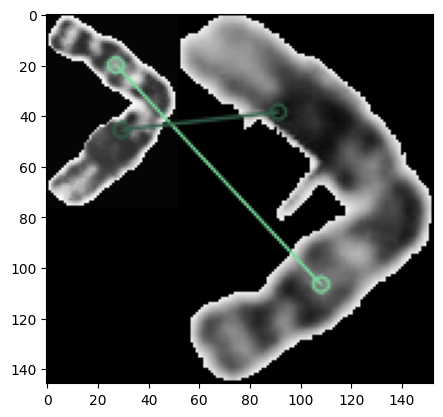

3.3333333333333335

In [52]:
# 不翻转
ai_rst_idx = 0
kyt_rst_idx = 0
ai_bbox = clahe_image(ai_rst_simple_lst[ai_rst_idx]['bbg_bbox'], 4, (4,4))
kyt_bbox = kyt_rst_simple_lst[kyt_rst_idx]['bbg_bbox']
sim1, sim1_ai_keys, sim1_kyt_keys, sim1_good = sift_similarity_on_roi_ex(ai_bbox, kyt_bbox)
sim1_img = cv2.drawMatchesKnn(ai_bbox, sim1_ai_keys, kyt_bbox, sim1_kyt_keys, sim1_good, None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(sim1_img)
plt.show()
sim1

In [53]:
tmp_ai_id = f"{ai_rst_simple_lst[ai_rst_idx]['chromo_id']}-{ai_rst_simple_lst[ai_rst_idx]['position_idx']}"
tmp_kyt_id = f"{kyt_rst_simple_lst[kyt_rst_idx]['chromo_id']}-{kyt_rst_simple_lst[kyt_rst_idx]['position_idx']}"

new_fp = os.path.join(SAVE_DIR, f"SIFT_NO_Flip_match_{tmp_ai_id}-{tmp_kyt_id}.png")
cv_imwrite(new_fp, sim1_img)

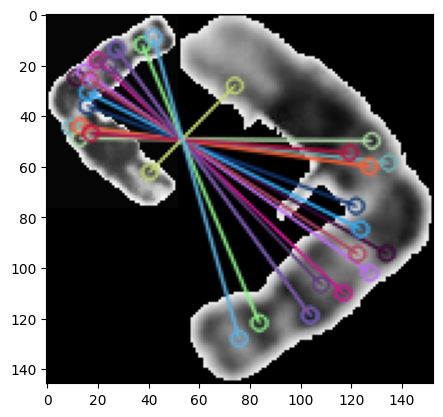

26.666666666666668

In [54]:
# 水平翻转
ai_bbox_v_flip = cv2.flip(ai_bbox, 1)
sim2, sim2_ai_keys, sim2_kyt_keys, sim2_good = sift_similarity_on_roi_ex(ai_bbox_v_flip, kyt_bbox)
sim2_img = cv2.drawMatchesKnn(ai_bbox_v_flip, sim2_ai_keys, kyt_bbox, sim2_kyt_keys, sim2_good, None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(sim2_img)
plt.show()
sim2

In [55]:
new_fp = os.path.join(SAVE_DIR, f"SIFT_V_Flip_match_{tmp_ai_id}-{tmp_kyt_id}.png")
cv_imwrite(new_fp, sim2_img)

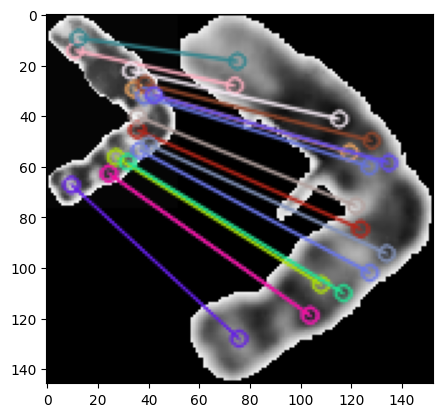

26.666666666666668

In [56]:
# 垂直翻转
ai_bbox_h_flip = cv2.flip(ai_bbox, 0)
sim3, sim3_ai_keys, sim3_kyt_keys, sim3_good = sift_similarity_on_roi_ex(ai_bbox_h_flip, kyt_bbox)
sim3_img = cv2.drawMatchesKnn(ai_bbox_h_flip, sim3_ai_keys, kyt_bbox, sim3_kyt_keys, sim3_good, None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(sim3_img)
plt.show()
sim3

In [57]:
new_fp = os.path.join(SAVE_DIR, f"SIFT_H_Flip_match_{tmp_ai_id}-{tmp_kyt_id}.png")
cv_imwrite(new_fp, sim3_img)

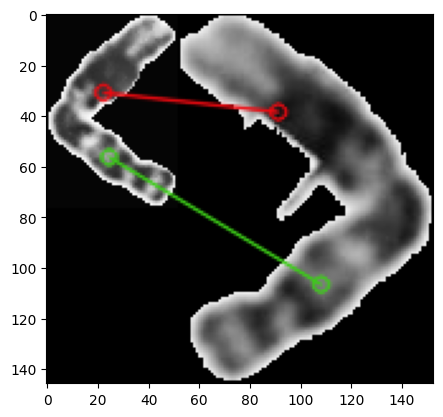

3.3333333333333335

In [58]:
# 水平垂直翻转
ai_bbox_vh_flip = cv2.flip(ai_bbox, -1)
sim4, sim4_ai_keys, sim4_kyt_keys, sim4_good = sift_similarity_on_roi_ex(ai_bbox_vh_flip, kyt_bbox)
sim4_img = cv2.drawMatchesKnn(ai_bbox_vh_flip, sim4_ai_keys, kyt_bbox, sim4_kyt_keys, sim4_good, None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(sim4_img)
plt.show()
sim4
# 结论：经过水平和垂直flip后其匹配到的特征点最多

In [59]:
new_fp = os.path.join(SAVE_DIR, f"SIFT_VH_Flip_match_{tmp_ai_id}-{tmp_kyt_id}.png")
cv_imwrite(new_fp, sim4_img)

In [60]:
# start to assessment AI Result for classfication
st = time.time()
for ai_idx, ai_rst in enumerate(ai_rst_simple_lst):
    max_sim = 0
    ai_rst_on_max = None
    kyt_rst_on_max = None
    upsidedown_on_max = False
    ai_idx_on_max = 0
    kyt_idx_on_max = 0
    for kyt_idx, kyt_rst in enumerate(kyt_rst_simple_lst):
        # 不翻转
        sim1 = sift_similarity_on_roi(ai_rst['bbg_bbox'], kyt_rst['bbg_bbox'])
        # 水平翻转:1
        sim2 = sift_similarity_on_roi(cv2.flip(ai_rst['bbg_bbox'], 1), kyt_rst['bbg_bbox'])
        # 垂直翻转:0
        sim3 = sift_similarity_on_roi(cv2.flip(ai_rst['bbg_bbox'], 0), kyt_rst['bbg_bbox'])
        # 水平垂直翻转:-1
        sim4 = sift_similarity_on_roi(cv2.flip(ai_rst['bbg_bbox'], -1), kyt_rst['bbg_bbox'])

        sim = max(sim1, sim2, sim3, sim4)

        if sim > max_sim:
            max_sim = sim
            ai_rst_on_max = ai_rst
            kyt_rst_on_max = kyt_rst
            ai_idx_on_max = ai_idx
            kyt_idx_on_max = kyt_idx
            sim_h_flip_max = max(sim1, sim2)
            sim_v_flip_max = max(sim3, sim4)
            if sim_v_flip_max > sim_h_flip_max:
                upsidedown_on_max = True
            else:
                upsidedown_on_max = False

    ai_rst_on_max['upsidedown'] = upsidedown_on_max
    # 打印 染色体编号对不上 和 颠倒的
    # if ai_rst_on_max['chromo_id'].lstrip('0') == kyt_rst_on_max['chromo_id'] and ai_rst_on_max['upsidedown'] == True:
    #     print(f"AI_RST[{ai_rst_on_max['chromo_id'].lstrip('0')}]-KYT_RST[{kyt_rst_on_max['chromo_id']}] = {max_sim:.2f}% -> 颠倒")
    # elif ai_rst_on_max['chromo_id'].lstrip('0') != kyt_rst_on_max['chromo_id']:
    #     print(f"AI_RST[{ai_rst_on_max['chromo_id']}]-KYT_RST[{kyt_rst_on_max['chromo_id']}] = {max_sim:.2f}%")
    # else:
    #     pass

    # 只打印 染色体编号对不上的
    # if ai_rst_on_max['chromo_id'].lstrip('0') != kyt_rst_on_max['chromo_id']:
    #     print(f"AI_RST[{ai_rst_on_max['chromo_id'].lstrip('0')}.{ai_rst_on_max['position_idx']}]-KYT_RST[{kyt_rst_on_max['chromo_id']}.{kyt_rst_on_max['position_idx']}] = {max_sim:.2f}%")

    # 打印所有
    print(f"AI_RST{ai_idx_on_max}-[{ai_rst_on_max['chromo_id'].lstrip('0')}.{ai_rst_on_max['position_idx']}]=>KYT_RST{kyt_idx_on_max}-[{kyt_rst_on_max['chromo_id']}.{kyt_rst_on_max['position_idx']}] = {max_sim:.2f}% {ai_rst_on_max['upsidedown']}")
et = time.time()
print(et - st)
# 实测用 cv2.BFMatcher() 比 cv2.FlannBasedMatcher() 要快，前者22.59秒，后者31.54秒

AI_RST0-[1.0]=>KYT_RST0-[1.0] = 18.33% False
AI_RST1-[1.1]=>KYT_RST1-[1.1] = 27.87% True
AI_RST2-[2.0]=>KYT_RST15-[8.1] = 15.91% False
AI_RST3-[11.0]=>KYT_RST22-[12.0] = 16.67% False
AI_RST4-[11.1]=>KYT_RST21-[11.1] = 13.64% False
AI_RST5-[12.0]=>KYT_RST22-[12.0] = 40.00% True
AI_RST6-[12.1]=>KYT_RST35-[19.0] = 17.65% False
AI_RST7-[13.0]=>KYT_RST25-[13.1] = 25.93% False
AI_RST8-[13.1]=>KYT_RST44-[Y.0] = 20.00% False
AI_RST9-[13.2]=>KYT_RST26-[14.0] = 29.41% False
AI_RST10-[13.3]=>KYT_RST35-[19.0] = 15.00% False
AI_RST11-[14.0]=>KYT_RST24-[13.0] = 20.00% True
AI_RST12-[14.1]=>KYT_RST27-[14.1] = 16.67% False
AI_RST13-[14.2]=>KYT_RST33-[18.0] = 15.79% False
AI_RST14-[14.3]=>KYT_RST35-[19.0] = 13.33% False
AI_RST15-[15.0]=>KYT_RST21-[11.1] = 18.18% False
AI_RST16-[15.1]=>KYT_RST35-[19.0] = 23.53% False
AI_RST17-[16.0]=>KYT_RST31-[16.1] = 53.85% False
AI_RST18-[16.1]=>KYT_RST35-[19.0] = 13.33% False
AI_RST19-[17.0]=>KYT_RST30-[16.0] = 12.50% False
AI_RST20-[17.1]=>KYT_RST30-[16.0] = 20.83%

In [61]:
# start to assessment AI Result for classfication
# 对AI的染色体进行增强处理后，再用SIFT进行特征匹配
st = time.time()
for ai_idx, ai_rst in enumerate(ai_rst_simple_lst):
    max_sim = 0
    ai_rst_on_max = None
    kyt_rst_on_max = None
    upsidedown_on_max = False
    ai_idx_on_max = 0
    kyt_idx_on_max = 0
    for kyt_idx, kyt_rst in enumerate(kyt_rst_simple_lst):
        # 不翻转
        enhanced_ai_rst_bbox = clahe_image(ai_rst['bbg_bbox'], 10, (8,8))
        sim1 = sift_similarity_on_roi(enhanced_ai_rst_bbox, kyt_rst['bbg_bbox'])
        # 水平翻转:1
        sim2 = sift_similarity_on_roi(cv2.flip(enhanced_ai_rst_bbox, 1), kyt_rst['bbg_bbox'])
        # 垂直翻转:0
        sim3 = sift_similarity_on_roi(cv2.flip(enhanced_ai_rst_bbox, 0), kyt_rst['bbg_bbox'])
        # 水平垂直翻转:-1
        sim4 = sift_similarity_on_roi(cv2.flip(enhanced_ai_rst_bbox, -1), kyt_rst['bbg_bbox'])

        sim = max(sim1, sim2, sim3, sim4)

        if sim > max_sim:
            max_sim = sim
            ai_rst_on_max = ai_rst
            kyt_rst_on_max = kyt_rst
            ai_idx_on_max = ai_idx
            kyt_idx_on_max = kyt_idx
            sim_h_flip_max = max(sim1, sim2)
            sim_v_flip_max = max(sim3, sim4)
            if sim_v_flip_max > sim_h_flip_max:
                upsidedown_on_max = True
            else:
                upsidedown_on_max = False

    ai_rst_on_max['upsidedown'] = upsidedown_on_max
    # 打印 染色体编号对不上 和 颠倒的
    # if ai_rst_on_max['chromo_id'].lstrip('0') == kyt_rst_on_max['chromo_id'] and ai_rst_on_max['upsidedown'] == True:
    #     print(f"AI_RST[{ai_rst_on_max['chromo_id'].lstrip('0')}]-KYT_RST[{kyt_rst_on_max['chromo_id']}] = {max_sim:.2f}% -> 颠倒")
    # elif ai_rst_on_max['chromo_id'].lstrip('0') != kyt_rst_on_max['chromo_id']:
    #     print(f"AI_RST[{ai_rst_on_max['chromo_id']}]-KYT_RST[{kyt_rst_on_max['chromo_id']}] = {max_sim:.2f}%")
    # else:
    #     pass

    # 只打印 染色体编号对不上的
    # if ai_rst_on_max['chromo_id'].lstrip('0') != kyt_rst_on_max['chromo_id']:
    #     print(f"AI_RST[{ai_rst_on_max['chromo_id'].lstrip('0')}.{ai_rst_on_max['position_idx']}]-KYT_RST[{kyt_rst_on_max['chromo_id']}.{kyt_rst_on_max['position_idx']}] = {max_sim:.2f}%")

    # 打印所有
    print(f"AI_RST{ai_idx_on_max}-[{ai_rst_on_max['chromo_id'].lstrip('0')}.{ai_rst_on_max['position_idx']}]=>KYT_RST{kyt_idx_on_max}-[{kyt_rst_on_max['chromo_id']}.{kyt_rst_on_max['position_idx']}] = {max_sim:.2f}% {ai_rst_on_max['upsidedown']}")
et = time.time()
print(et - st)
# 实测用 cv2.BFMatcher() 比 cv2.FlannBasedMatcher() 要快，前者22.59秒，后者31.54秒

AI_RST0-[1.0]=>KYT_RST0-[1.0] = 16.67% True
AI_RST1-[1.1]=>KYT_RST1-[1.1] = 21.31% False
AI_RST2-[2.0]=>KYT_RST3-[2.1] = 16.67% False
AI_RST3-[11.0]=>KYT_RST20-[11.0] = 13.33% True
AI_RST4-[11.1]=>KYT_RST21-[11.1] = 9.09% False
AI_RST5-[12.0]=>KYT_RST14-[8.0] = 15.38% False
AI_RST6-[12.1]=>KYT_RST23-[12.1] = 14.63% True
AI_RST7-[13.0]=>KYT_RST25-[13.1] = 11.11% False
AI_RST8-[13.1]=>KYT_RST32-[17.0] = 8.70% False
AI_RST9-[13.2]=>KYT_RST26-[14.0] = 14.29% False
AI_RST10-[13.3]=>KYT_RST30-[16.0] = 12.50% True
AI_RST11-[14.0]=>KYT_RST24-[13.0] = 24.00% False
AI_RST12-[14.1]=>KYT_RST27-[14.1] = 11.11% False
AI_RST13-[14.2]=>KYT_RST21-[11.1] = 11.54% True
AI_RST14-[14.3]=>KYT_RST42-[22.1] = 13.33% False
AI_RST15-[15.0]=>KYT_RST32-[17.0] = 17.39% False
AI_RST16-[15.1]=>KYT_RST29-[15.1] = 15.79% False
AI_RST17-[16.0]=>KYT_RST38-[20.1] = 15.79% True
AI_RST18-[16.1]=>KYT_RST30-[16.0] = 16.67% False
AI_RST19-[17.0]=>KYT_RST32-[17.0] = 17.39% False
AI_RST20-[17.1]=>KYT_RST39-[21.0] = 12.50% False

In [62]:
# 试试cv2.matchShapes
# 在使用cv2.matchShapes()进行形状匹配时，输入的两个轮廓（contours）不必手动进行归一化操作。
# 这是因为matchShapes函数内部计算形状相似度时，使用的是基于Hu矩的方法，
# 而Hu矩本身具有一定的旋转、缩放和平移不变性。这意味着即使两个形状在大小、方向或位置上有所不同，
# matchShapes也能有效地比较它们的相似度。
st = time.time()
for ai_idx, ai_rst in enumerate(ai_rst_simple_lst):
    min_match = 999999999
    ai_rst_on_min = None
    kyt_rst_on_min = None
    ai_idx_on_min = 0
    kyt_idx_on_min = 0
    for kyt_idx, kyt_rst in enumerate(kyt_rst_simple_lst):
        ai_rst_cntr = ai_rst['cntr']
        kyt_rst_cntr = kyt_rst['cntr']
        match = cv2.matchShapes(ai_rst_cntr, kyt_rst_cntr, cv2.CONTOURS_MATCH_I3, 0.0)

        if match < min_match:
            min_match = match
            ai_rst_on_min = ai_rst
            kyt_rst_on_min = kyt_rst
            ai_idx_on_min = ai_idx
            kyt_idx_on_min = kyt_idx

    # 打印所有
    print(f"AI_RST{ai_idx_on_min}-[{ai_rst_on_min['chromo_id'].lstrip('0')}.{ai_rst_on_min['position_idx']}]=>KYT_RST{kyt_idx_on_min}-[{kyt_rst_on_min['chromo_id']}.{kyt_rst_on_min['position_idx']}] = {min_match:.2f}%")
et = time.time()
print(et - st)

AI_RST0-[1.0]=>KYT_RST0-[1.0] = 0.02%
AI_RST1-[1.1]=>KYT_RST1-[1.1] = 0.18%
AI_RST2-[2.0]=>KYT_RST3-[2.1] = 0.13%
AI_RST3-[11.0]=>KYT_RST13-[7.1] = 0.06%
AI_RST4-[11.1]=>KYT_RST12-[7.0] = 0.15%
AI_RST5-[12.0]=>KYT_RST15-[8.1] = 0.07%
AI_RST6-[12.1]=>KYT_RST23-[12.1] = 0.05%
AI_RST7-[13.0]=>KYT_RST25-[13.1] = 0.02%
AI_RST8-[13.1]=>KYT_RST34-[18.1] = 0.09%
AI_RST9-[13.2]=>KYT_RST28-[15.0] = 0.05%
AI_RST10-[13.3]=>KYT_RST20-[11.0] = 0.08%
AI_RST11-[14.0]=>KYT_RST28-[15.0] = 0.05%
AI_RST12-[14.1]=>KYT_RST29-[15.1] = 0.07%
AI_RST13-[14.2]=>KYT_RST43-[X.0] = 0.05%
AI_RST14-[14.3]=>KYT_RST41-[22.0] = 0.21%
AI_RST15-[15.0]=>KYT_RST29-[15.1] = 0.05%
AI_RST16-[15.1]=>KYT_RST25-[13.1] = 0.05%
AI_RST17-[16.0]=>KYT_RST30-[16.0] = 0.04%
AI_RST18-[16.1]=>KYT_RST30-[16.0] = 0.04%
AI_RST19-[17.0]=>KYT_RST27-[14.1] = 0.03%
AI_RST20-[17.1]=>KYT_RST41-[22.0] = 0.41%
AI_RST21-[18.0]=>KYT_RST35-[19.0] = 0.01%
AI_RST22-[18.1]=>KYT_RST35-[19.0] = 0.06%
AI_RST23-[19.0]=>KYT_RST35-[19.0] = 0.04%
AI_RST24-[19.1]